In [2]:
import cv2
import numpy as np
import torch
import torch.nn.functional as func
import matplotlib.pyplot as plt

from lisrd.models import get_model
from lisrd.models.base_model import Mode
from lisrd.models.keypoint_detectors import SP_detect, load_SP_net
from lisrd.utils.geometry_utils import extract_descriptors, lisrd_matcher, filter_outliers_ransac
from utils import plot_images, plot_keypoints, plot_matches
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load images

/home/chiebotgpuhq/anaconda3/envs/lisrd/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


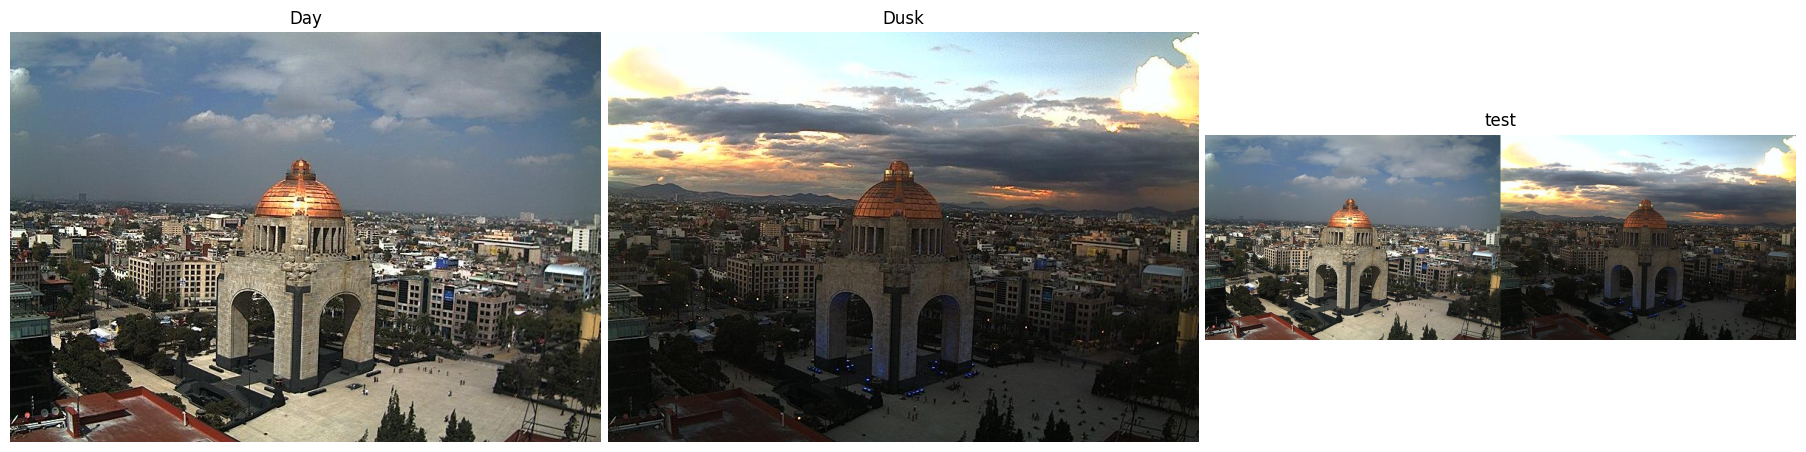

In [10]:
img1 = cv2.cvtColor(cv2.imread('../assets/rdnim_samples/day.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../assets/rdnim_samples/dusk.jpg'), cv2.COLOR_BGR2RGB)
img_size = img1.shape[:2]
img1=cv2.copyMakeBorder(img1,10,0,0,0,cv2.BORDER_CONSTANT,value=(0,0,0))
plot_images([img1, img2], ['Day', 'Dusk'])

## Load the models

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the LISRD model
model_config = {'name': 'lisrd', 'desc_size': 128, 'tile': 3, 'n_clusters': 8, 'meta_desc_dim': 128,
                'learning_rate': 0.001, 'compute_meta_desc': True, 'freeze_local_desc': False}
lisrd_net = get_model('lisrd')(None, model_config, device)
checkpoint_path = '../weights/lisrd_vidit.pth'
lisrd_net.load(checkpoint_path, Mode.EXPORT)
lisrd_net._net.eval()

# Load the keypoint model, here SuperPoint
kp_net = load_SP_net(conf_thresh=0.015, cuda=torch.cuda.is_available(), nms_dist=4, nn_thresh=0.7)

## Run the networks and match the images

In [ ]:
with torch.no_grad():
    # Keypoint detection
    kp1 = SP_detect(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), kp_net)
    gpu_kp1 = torch.tensor(kp1, dtype=torch.float, device=device)[:, :2]
    kp2 = SP_detect(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY), kp_net)
    gpu_kp2 = torch.tensor(kp2, dtype=torch.float, device=device)[:, :2]
    
    # Descriptor inference
    gpu_img1 = torch.tensor(img1, dtype=torch.float, device=device)
    inputs1 = {'image0': gpu_img1.unsqueeze(0).permute(0, 3, 1, 2)}
    outputs1 = lisrd_net._forward(inputs1, Mode.EXPORT, model_config)
    desc1 = outputs1['descriptors']
    meta_desc1 = outputs1['meta_descriptors']
    gpu_img2 = torch.tensor(img2, dtype=torch.float, device=device)
    inputs2 = {'image0': gpu_img2.unsqueeze(0).permute(0, 3, 1, 2)}
    outputs2 = lisrd_net._forward(inputs2, Mode.EXPORT, model_config)
    desc2 = outputs2['descriptors']
    meta_desc2 = outputs2['meta_descriptors']
    
    # Sample the descriptors at the keypoint positions
    desc1, meta_desc1 = extract_descriptors(gpu_kp1, desc1, meta_desc1, img_size)
    desc2, meta_desc2 = extract_descriptors(gpu_kp2, desc2, meta_desc2, img_size)
    
    # Nearest neighbor matching based on the LISRD descriptors
    matches = lisrd_matcher(desc1, desc2, meta_desc1, meta_desc2).cpu().numpy()
    
# Refine the matches with RANSAC
matched_kp1, matched_kp2 = kp1[matches[:, 0]][:, [1, 0]], kp2[matches[:, 1]][:, [1, 0]]
matched_kp1, matched_kp2 = filter_outliers_ransac(matched_kp1, matched_kp2)

/home/chiebotgpuhq/anaconda3/envs/lisrd/lib/python3.7/site-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


torch.Size([1182, 4, 1042])
> /home/chiebotgpuhq/MyCode/python/pytorch/LISRD/lisrd/utils/geometry_utils.py(116)lisrd_matcher()
    115     import ipdb; ipdb.set_trace()
--> 116     desc_sims = torch.einsum('nid,mid->nim', (desc1, desc2)) * desc_weights
    117     del desc1, desc2, desc_weights

ipdb> n
> /home/chiebotgpuhq/MyCode/python/pytorch/LISRD/lisrd/utils/geometry_utils.py(117)lisrd_matcher()
    116     desc_sims = torch.einsum('nid,mid->nim', (desc1, desc2)) * desc_weights
--> 117     del desc1, desc2, desc_weights
    118     desc_sims = torch.sum(desc_sims, dim=1)

ipdb> desc_sims.shape
torch.Size([1182, 4, 1042])
ipdb> n
> /home/chiebotgpuhq/MyCode/python/pytorch/LISRD/lisrd/utils/geometry_utils.py(118)lisrd_matcher()
    117     del desc1, desc2, desc_weights
--> 118     desc_sims = torch.sum(desc_sims, dim=1)
    119     nn12 = torch.max(desc_sims, dim=1)[1]

ipdb> n
> /home/chiebotgpuhq/MyCode/python/pytorch/LISRD/lisrd/utils/geometry_utils.py(119)lisrd_matcher()
    11

ipdb> mask.shape
torch.Size([1182])
ipdb> ids1[mask].shape
torch.Size([239])
ipdb> n
> /home/chiebotgpuhq/MyCode/python/pytorch/LISRD/lisrd/utils/geometry_utils.py(125)lisrd_matcher()
    124     matches = torch.stack([ids1[mask], nn12[mask]], dim=1)
--> 125     return matches
    126 

ipdb> match.shape
*** NameError: name 'match' is not defined
ipdb> matches.shape
torch.Size([239, 2])


In [ ]:
plot_images([img1, img2], ['Day', 'Dusk'])
plot_keypoints([kp1[:, [1, 0]], kp2[:, [1, 0]]], colors='red', ps=2)
plot_matches(matched_kp1, matched_kp2, color='lime', lw=1)